<a href="https://colab.research.google.com/github/mishra-bytes/Face-Orientation-Detector/blob/main/MediaPipe_FaceMesh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip uninstall -y mediapipe
!pip install -q mediapipe==0.10.31


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 10.8 MB/s eta 0:00:00



[1/5] /content/drive/MyDrive/InnerGize_Face/data/test/image_5afdb582_jpg.rf.0448c5767d7ab167c784e9977a637ab1.jpg


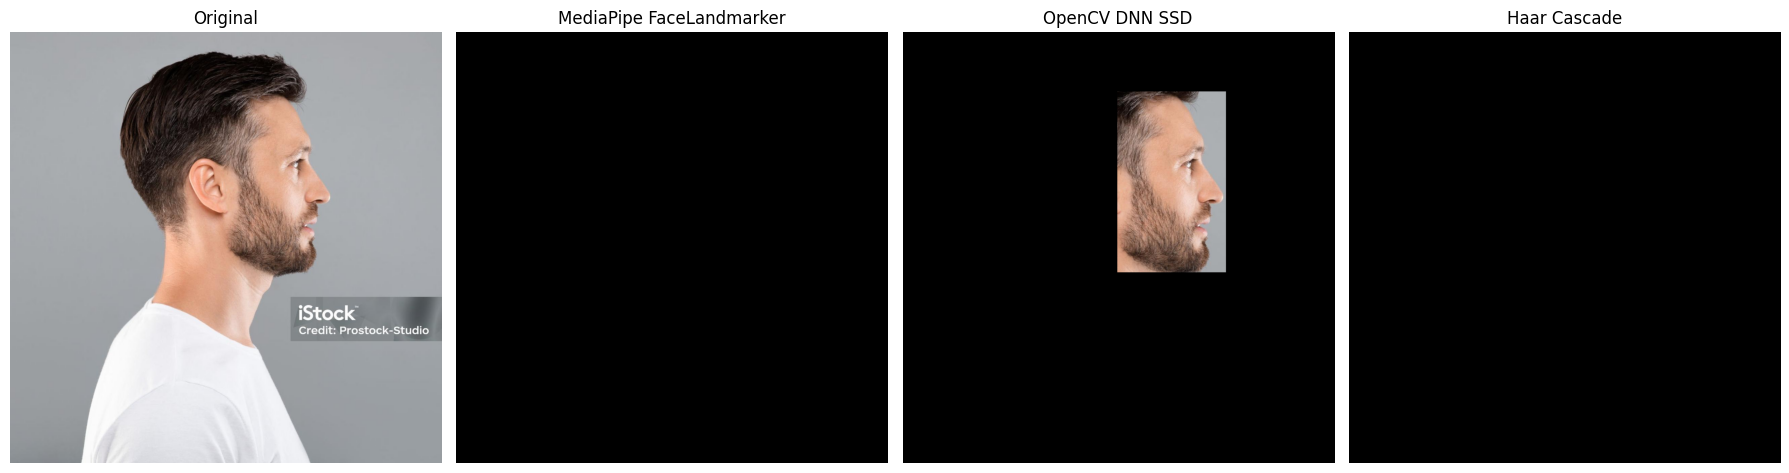


[2/5] /content/drive/MyDrive/InnerGize_Face/data/test/image_111_jpg.rf.4d48272178536ae296cba6456a39123b.jpg


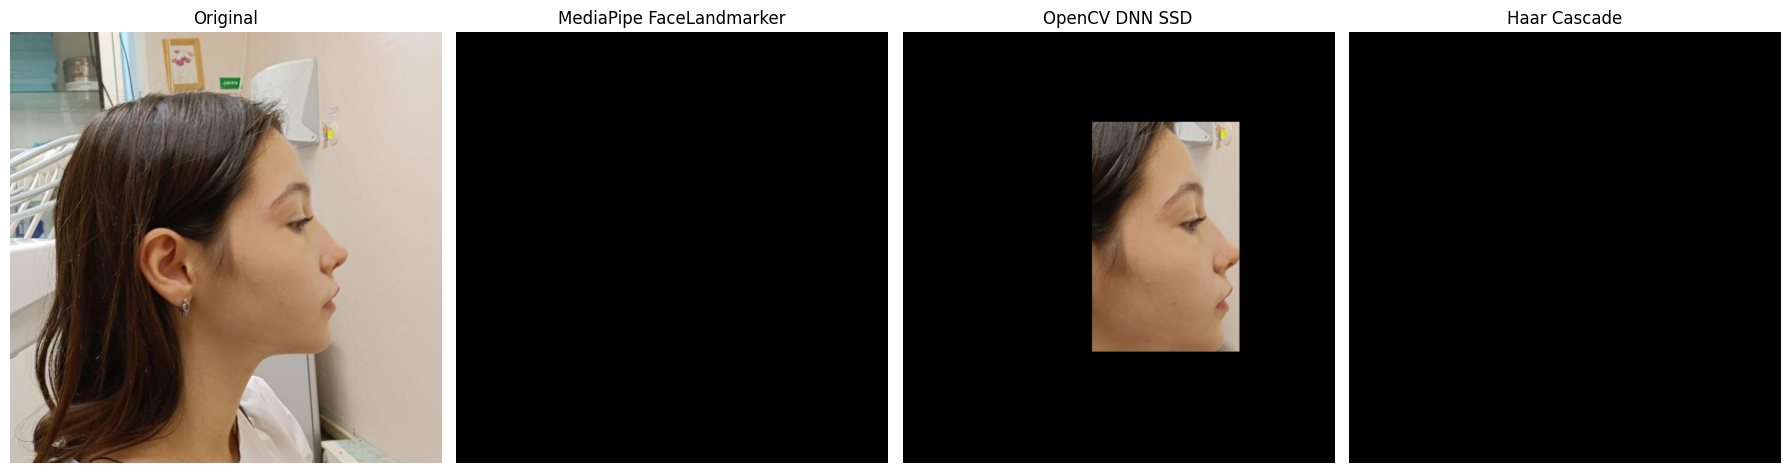


[3/5] /content/drive/MyDrive/InnerGize_Face/data/test/image_8b4a11f6_jpg.rf.acf28062eaa72c887bb1e0a1717c47da.jpg


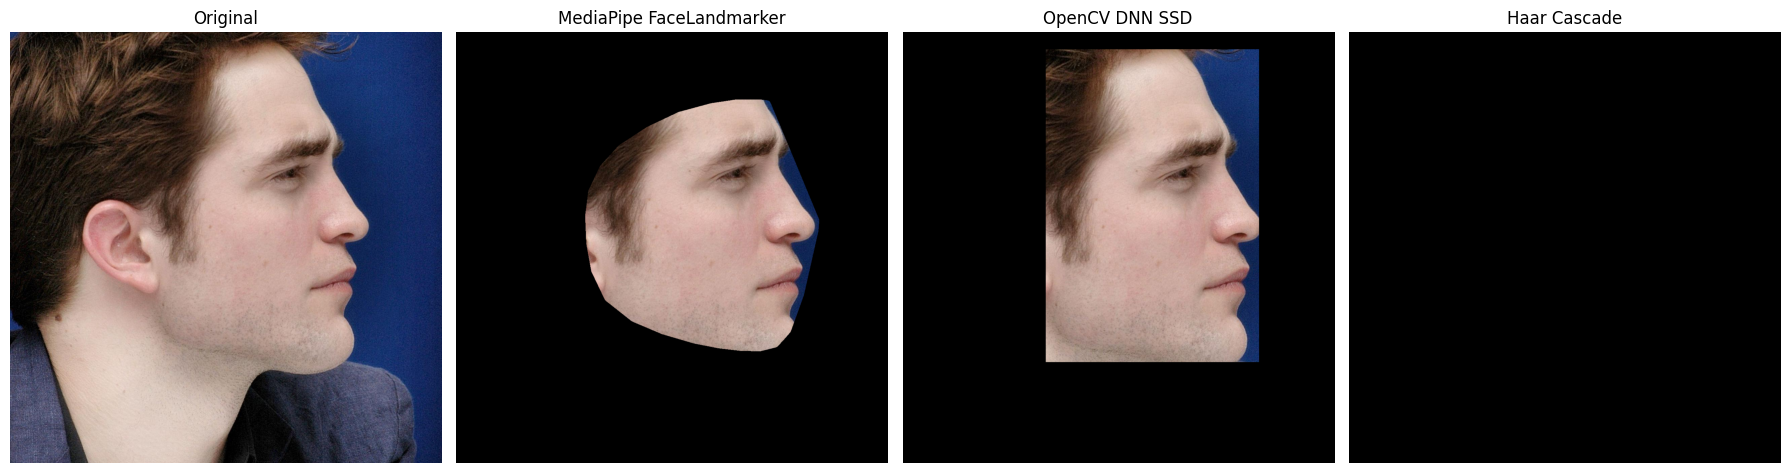


[4/5] /content/drive/MyDrive/InnerGize_Face/data/test/image_10_jpg.rf.9a988e9e88efd4d617431895da6ece5e.jpg


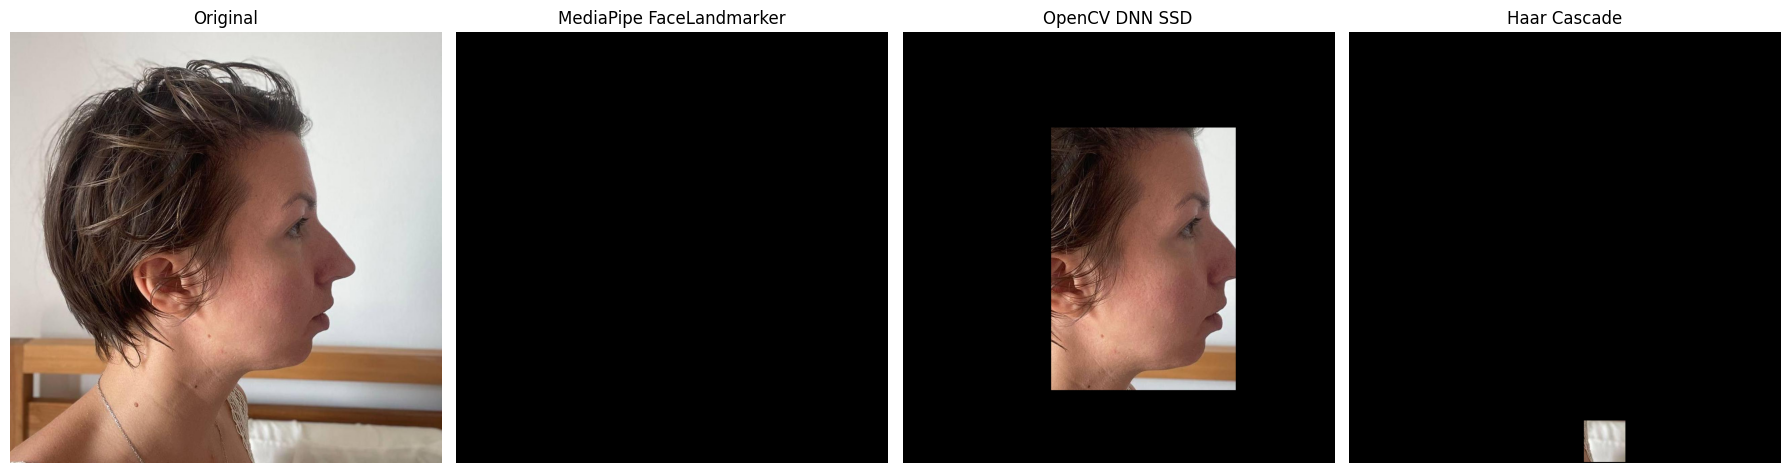


[5/5] /content/drive/MyDrive/InnerGize_Face/data/test/image_079aef63_jpg.rf.1aa5401acf8ac810ec0bcffe0bb9f670.jpg


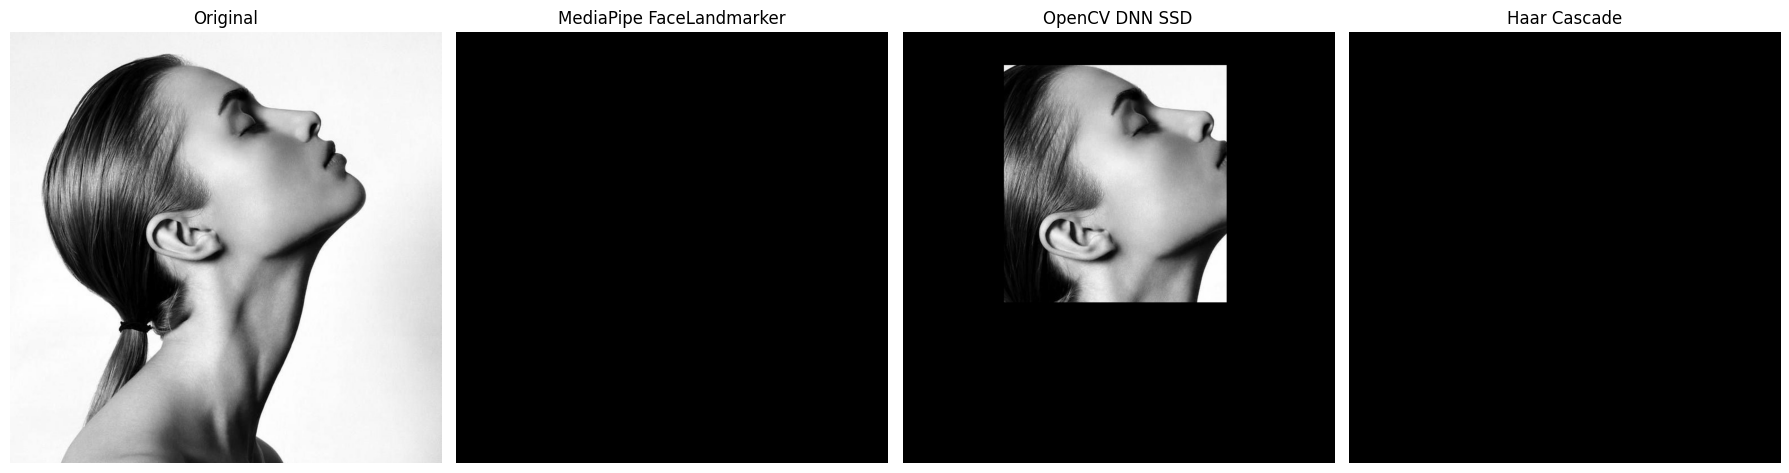

In [11]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

from mediapipe.tasks.python import vision
from mediapipe.tasks.python import BaseOptions

IMAGE_DIR = "/content/drive/MyDrive/InnerGize_Face/data/test"
NUM_SAMPLES = 5
GENERAL_EXPAND = 20


FACE_LANDMARKER_MODEL = "face_landmarker.task"

if not os.path.exists(FACE_LANDMARKER_MODEL):
    !wget -q -O face_landmarker.task \
    https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task


if not os.path.exists("deploy.prototxt"):
    !wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt

if not os.path.exists("res10_300x300_ssd_iter_140000.caffemodel"):
    !wget -q https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel


# MediaPipe FaceLandmarker
face_landmarker = vision.FaceLandmarker.create_from_options(
    vision.FaceLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=FACE_LANDMARKER_MODEL),
        num_faces=1
    )
)

# OpenCV DNN SSD
dnn_net = cv2.dnn.readNetFromCaffe(
    "deploy.prototxt",
    "res10_300x300_ssd_iter_140000.caffemodel"
)

# Haar Cascade
haar = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)


image_files = [
    os.path.join(IMAGE_DIR, f)
    for f in os.listdir(IMAGE_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]

samples = random.sample(image_files, NUM_SAMPLES)


for idx, img_path in enumerate(samples, 1):
    print(f"\n[{idx}/{NUM_SAMPLES}] {img_path}")

    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape

    mp_image = mp.Image(mp.ImageFormat.SRGB, img_rgb)


    # FaceLandmarker (Hull Mask)

    lm_result = face_landmarker.detect(mp_image)
    mask_lm = np.zeros((h, w), dtype=np.uint8)

    if lm_result.face_landmarks:
        pts = np.array(
            [[int(l.x * w), int(l.y * h)] for l in lm_result.face_landmarks[0]],
            dtype=np.int32
        )
        hull = cv2.convexHull(pts)
        cv2.fillConvexPoly(mask_lm, hull, 255)
        mask_lm = cv2.dilate(
            mask_lm,
            cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (GENERAL_EXPAND, GENERAL_EXPAND))
        )

    out_lm = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_lm)


    # OpenCV DNN SSD

    blob = cv2.dnn.blobFromImage(
        img_bgr, 1.0, (300, 300), (104.0, 177.0, 123.0)
    )
    dnn_net.setInput(blob)
    detections = dnn_net.forward()

    mask_dnn = np.zeros((h, w), dtype=np.uint8)
    if detections.shape[2] > 0:
        conf = detections[0, 0, 0, 2]
        if conf > 0.5:
            box = detections[0, 0, 0, 3:7] * np.array([w, h, w, h])
            x1, y1, x2, y2 = box.astype(int)
            mask_dnn[y1:y2, x1:x2] = 255

    out_dnn = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_dnn)


    # Haar Cascade

    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    faces = haar.detectMultiScale(gray, 1.1, 5)
    mask_haar = np.zeros((h, w), dtype=np.uint8)

    if len(faces):
        x, y, fw, fh = max(faces, key=lambda b: b[2] * b[3])
        mask_haar[y:y + fh, x:x + fw] = 255

    out_haar = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_haar)


    plt.figure(figsize=(18, 5))

    plt.subplot(1, 4, 1)
    plt.title("Original")
    plt.imshow(img_rgb)
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.title("MediaPipe FaceLandmarker")
    plt.imshow(out_lm)
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.title("OpenCV DNN SSD")
    plt.imshow(out_dnn)
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.title("Haar Cascade")
    plt.imshow(out_haar)
    plt.axis("off")

    plt.tight_layout()
    plt.show()



[1/5] /content/drive/MyDrive/InnerGize_Face/data/test/image_3f208053_jpg.rf.5cbe27db87625b705866e3f8a2895518.jpg


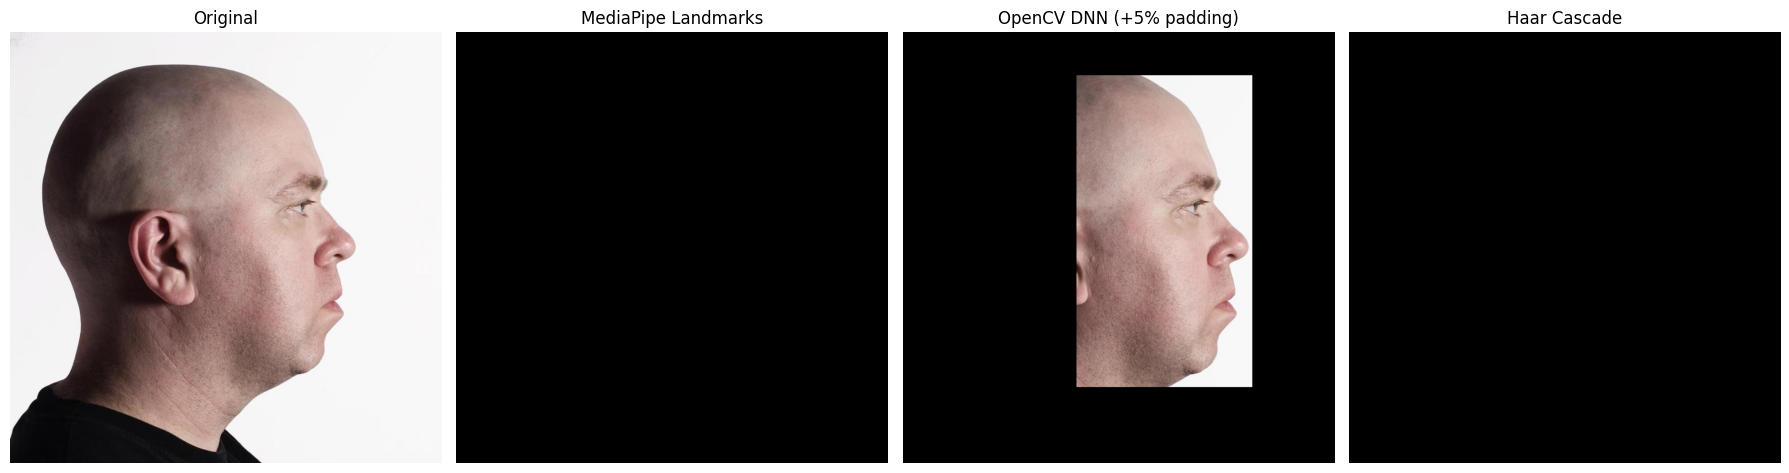


[2/5] /content/drive/MyDrive/InnerGize_Face/data/test/image_94_jpg.rf.6a778c78548456117b673ba5b707274b.jpg


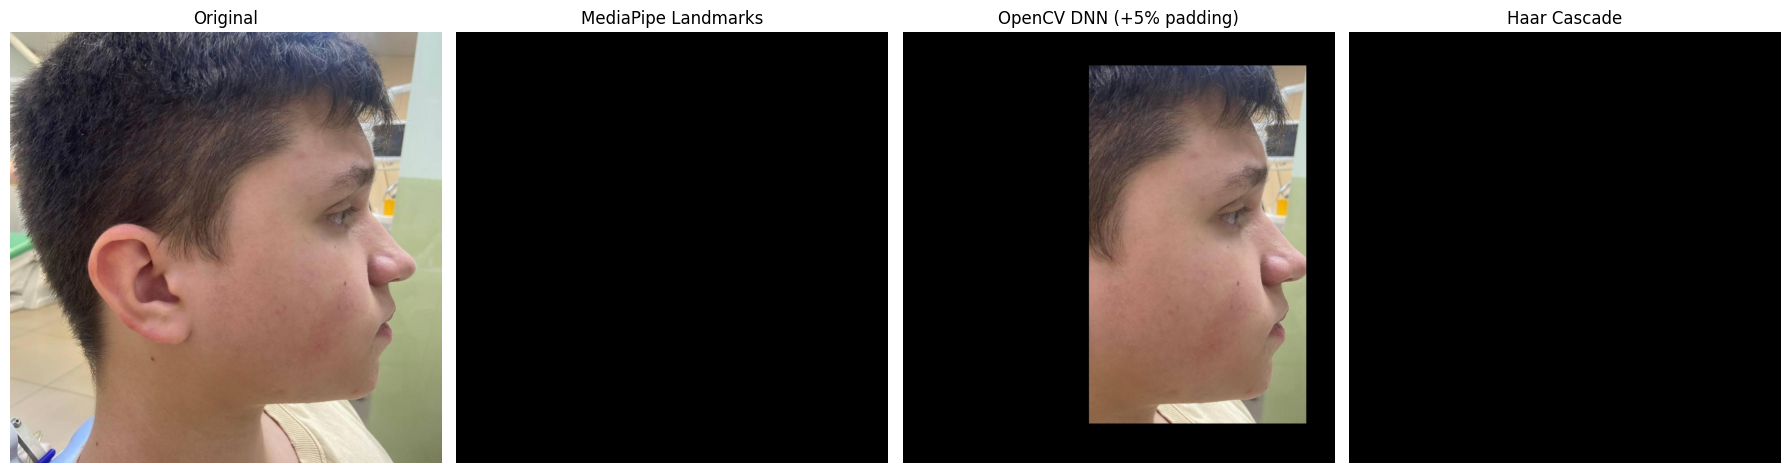


[3/5] /content/drive/MyDrive/InnerGize_Face/data/test/image_079aef63_jpg.rf.1aa5401acf8ac810ec0bcffe0bb9f670.jpg


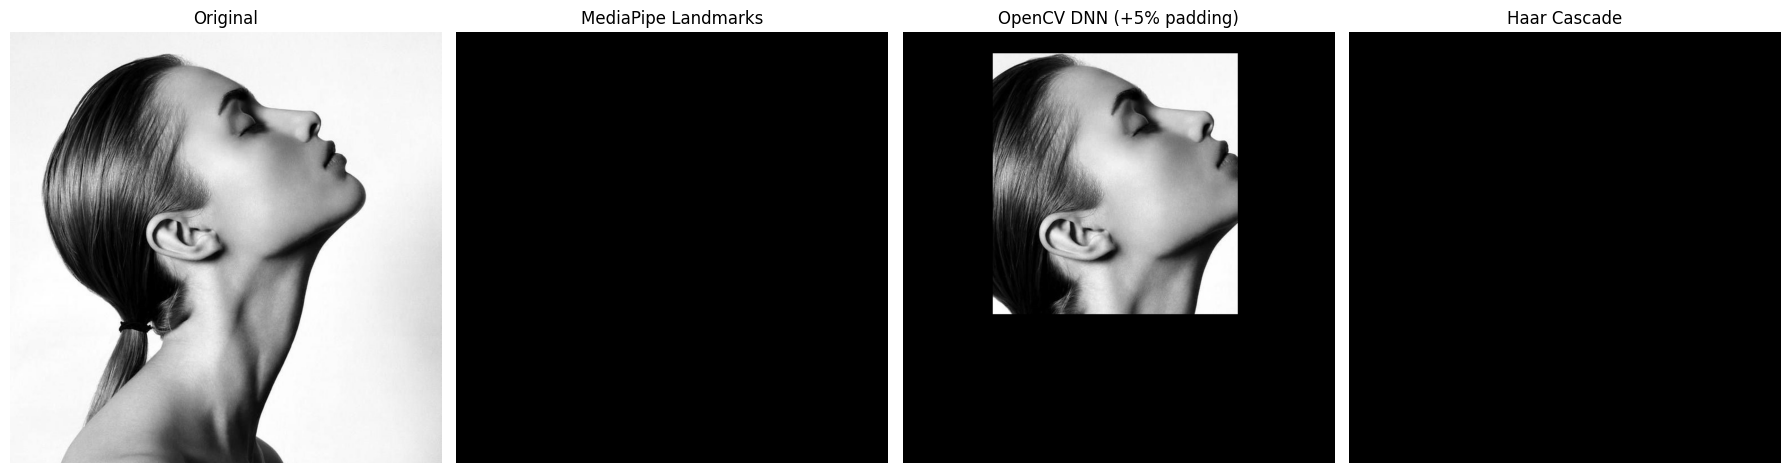


[4/5] /content/drive/MyDrive/InnerGize_Face/data/test/image_63_jpg.rf.23cd1c64d01e0fa1385685f32391e2f7.jpg


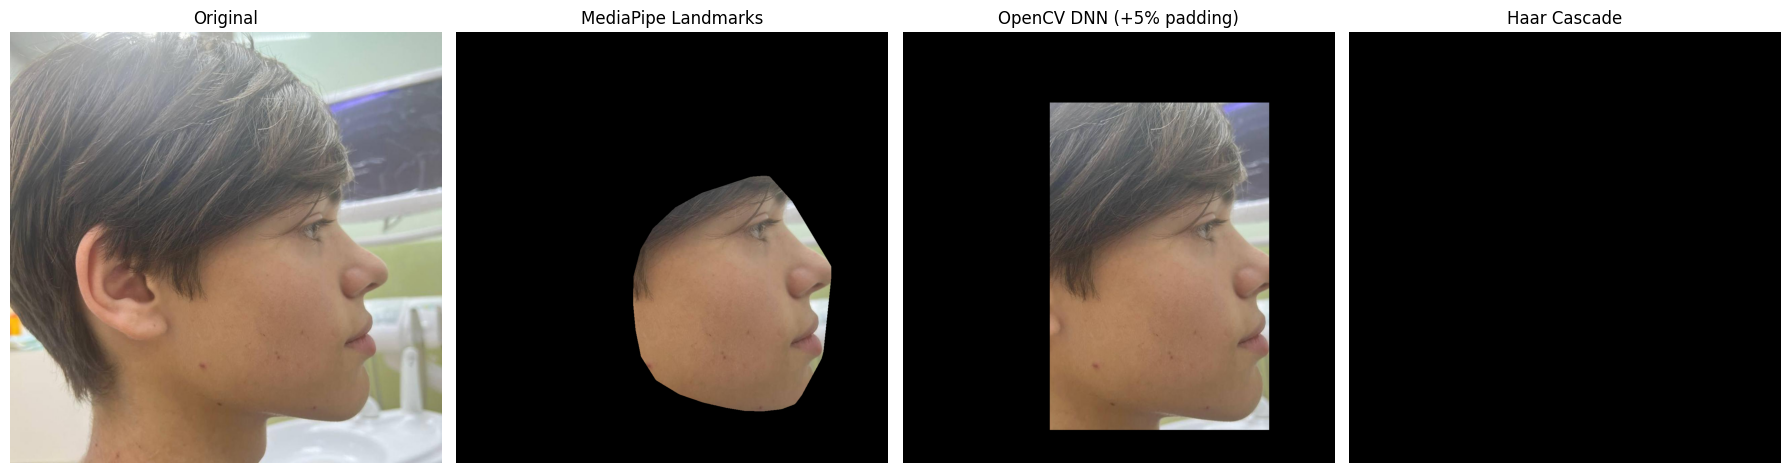


[5/5] /content/drive/MyDrive/InnerGize_Face/data/test/image_77617828_jpg.rf.25521e95b3b127838bf8ac7cc976cc0a.jpg


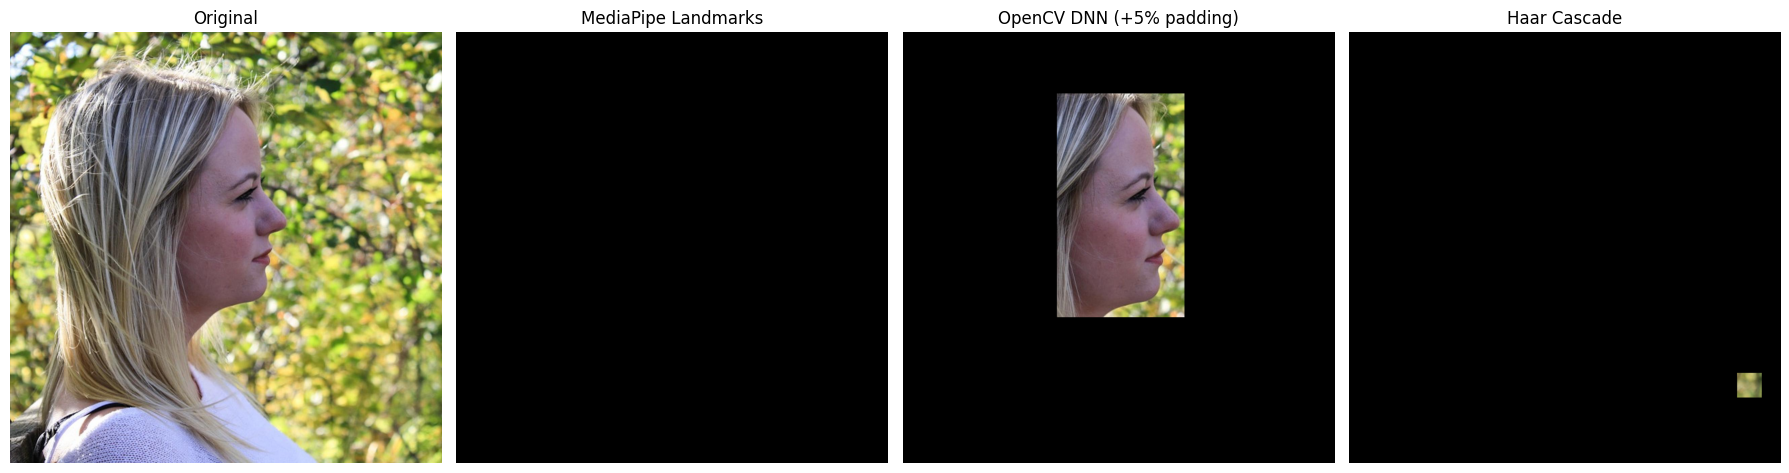

In [12]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

from mediapipe.tasks.python import vision
from mediapipe.tasks.python import BaseOptions


IMAGE_DIR = "/content/drive/MyDrive/InnerGize_Face/data/test"
NUM_SAMPLES = 5

GENERAL_EXPAND = 20
DNN_PADDING_RATIO = 0.05


FACE_LANDMARKER_MODEL = "face_landmarker.task"

if not os.path.exists(FACE_LANDMARKER_MODEL):
    !wget -q -O face_landmarker.task \
    https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task

if not os.path.exists("deploy.prototxt"):
    !wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt

if not os.path.exists("res10_300x300_ssd_iter_140000.caffemodel"):
    !wget -q https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel


face_landmarker = vision.FaceLandmarker.create_from_options(
    vision.FaceLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=FACE_LANDMARKER_MODEL),
        num_faces=1
    )
)

dnn_net = cv2.dnn.readNetFromCaffe(
    "deploy.prototxt",
    "res10_300x300_ssd_iter_140000.caffemodel"
)

haar = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)


image_files = [
    os.path.join(IMAGE_DIR, f)
    for f in os.listdir(IMAGE_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]

samples = random.sample(image_files, NUM_SAMPLES)


for idx, img_path in enumerate(samples, 1):
    print(f"\n[{idx}/{NUM_SAMPLES}] {img_path}")

    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape

    mp_image = mp.Image(mp.ImageFormat.SRGB, img_rgb)


    lm_result = face_landmarker.detect(mp_image)
    mask_lm = np.zeros((h, w), dtype=np.uint8)

    if lm_result.face_landmarks:
        pts = np.array(
            [[int(l.x * w), int(l.y * h)] for l in lm_result.face_landmarks[0]],
            dtype=np.int32
        )
        hull = cv2.convexHull(pts)
        cv2.fillConvexPoly(mask_lm, hull, 255)
        mask_lm = cv2.dilate(
            mask_lm,
            cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (GENERAL_EXPAND, GENERAL_EXPAND))
        )

    out_lm = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_lm)


    blob = cv2.dnn.blobFromImage(
        img_bgr, 1.0, (300, 300), (104.0, 177.0, 123.0)
    )
    dnn_net.setInput(blob)
    detections = dnn_net.forward()

    mask_dnn = np.zeros((h, w), dtype=np.uint8)

    if detections.shape[2] > 0:
        conf = detections[0, 0, 0, 2]
        if conf > 0.5:
            x1, y1, x2, y2 = (
                detections[0, 0, 0, 3:7] * np.array([w, h, w, h])
            ).astype(int)

            bw = x2 - x1
            bh = y2 - y1

            pad_w = int(bw * DNN_PADDING_RATIO)
            pad_h = int(bh * DNN_PADDING_RATIO)

            x1 = max(0, x1 - pad_w)
            y1 = max(0, y1 - pad_h)
            x2 = min(w, x2 + pad_w)
            y2 = min(h, y2 + pad_h)

            mask_dnn[y1:y2, x1:x2] = 255

    out_dnn = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_dnn)


    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    faces = haar.detectMultiScale(gray, 1.1, 5)
    mask_haar = np.zeros((h, w), dtype=np.uint8)

    if len(faces):
        x, y, fw, fh = max(faces, key=lambda b: b[2] * b[3])
        mask_haar[y:y + fh, x:x + fw] = 255

    out_haar = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_haar)

    plt.figure(figsize=(18, 5))

    plt.subplot(1, 4, 1)
    plt.title("Original")
    plt.imshow(img_rgb)
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.title("MediaPipe Landmarks")
    plt.imshow(out_lm)
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.title(f"OpenCV DNN (+{int(DNN_PADDING_RATIO*100)}% padding)")
    plt.imshow(out_dnn)
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.title("Haar Cascade")
    plt.imshow(out_haar)
    plt.axis("off")

    plt.tight_layout()
    plt.show()



[1/5] /content/drive/MyDrive/InnerGize_Face/data/test/image_261c14cc_jpg.rf.1e7590432e1e62a0e66a98fdd95deb5c.jpg
  FaceLandmarker : 17.22 ms
  OpenCV DNN SSD : 63.42 ms
  Haar Cascade  : 253.46 ms


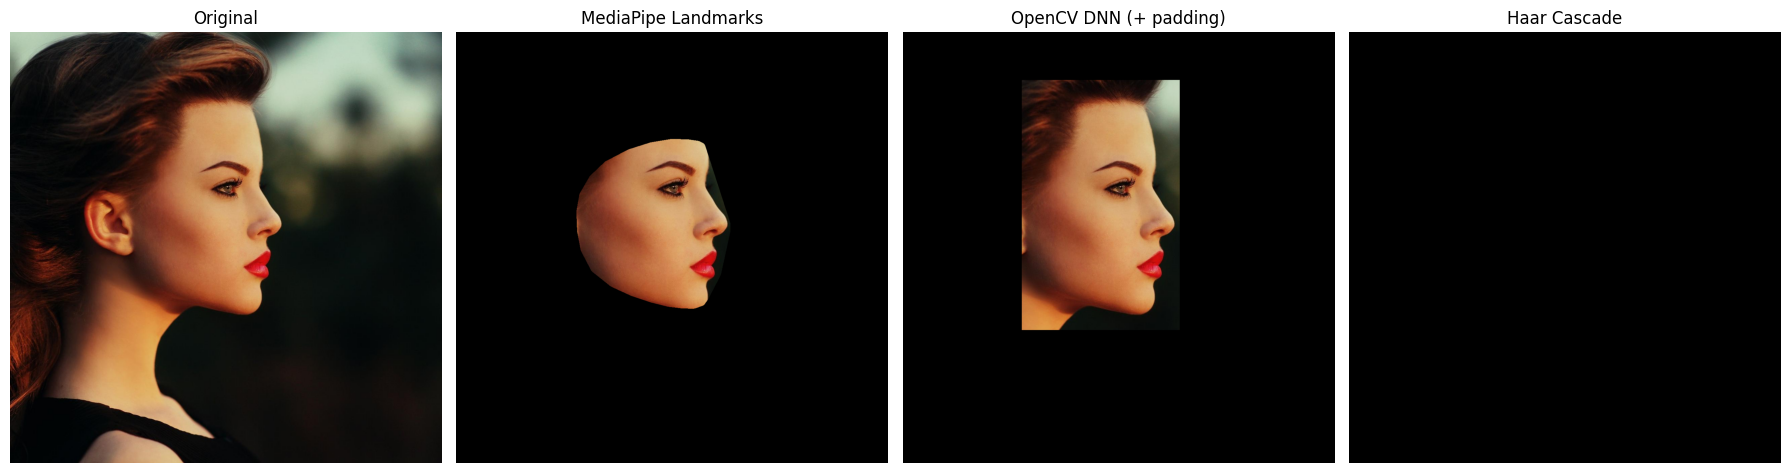


[2/5] /content/drive/MyDrive/InnerGize_Face/data/test/image_1d62f43b_jpg.rf.d57ee716e8e1a47ee8380af0a612d99b.jpg
  FaceLandmarker : 23.44 ms
  OpenCV DNN SSD : 43.53 ms
  Haar Cascade  : 391.73 ms


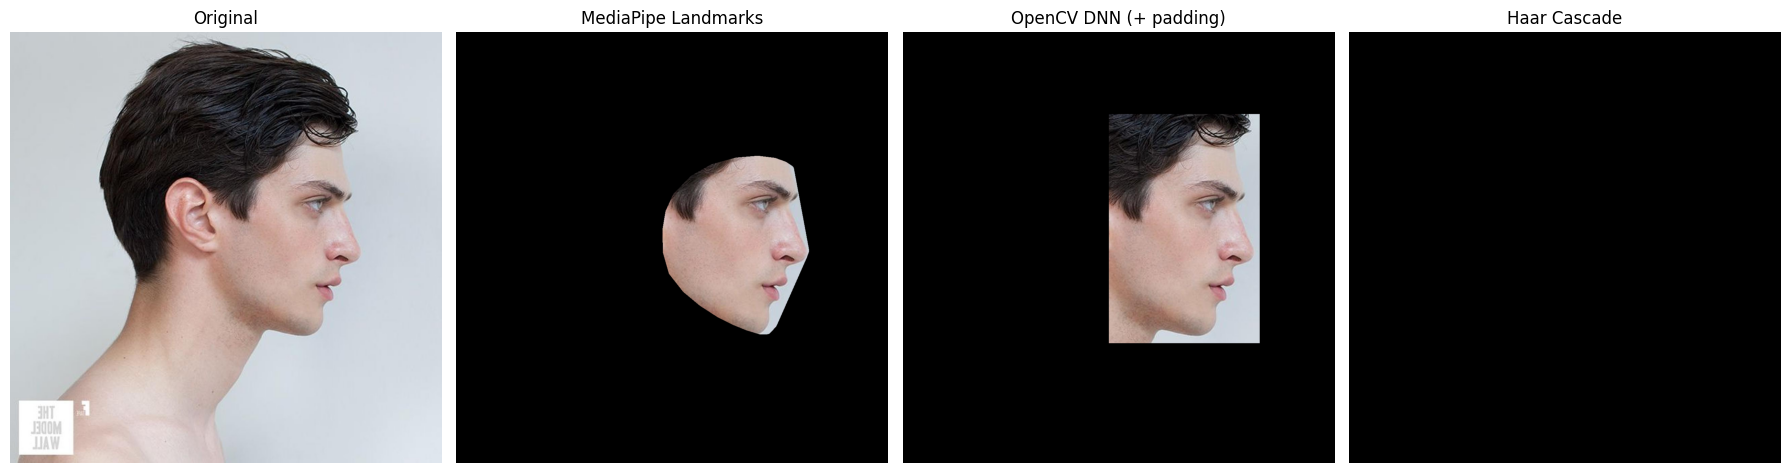


[3/5] /content/drive/MyDrive/InnerGize_Face/data/test/image_63_jpg.rf.23cd1c64d01e0fa1385685f32391e2f7.jpg
  FaceLandmarker : 23.77 ms
  OpenCV DNN SSD : 39.38 ms
  Haar Cascade  : 382.12 ms


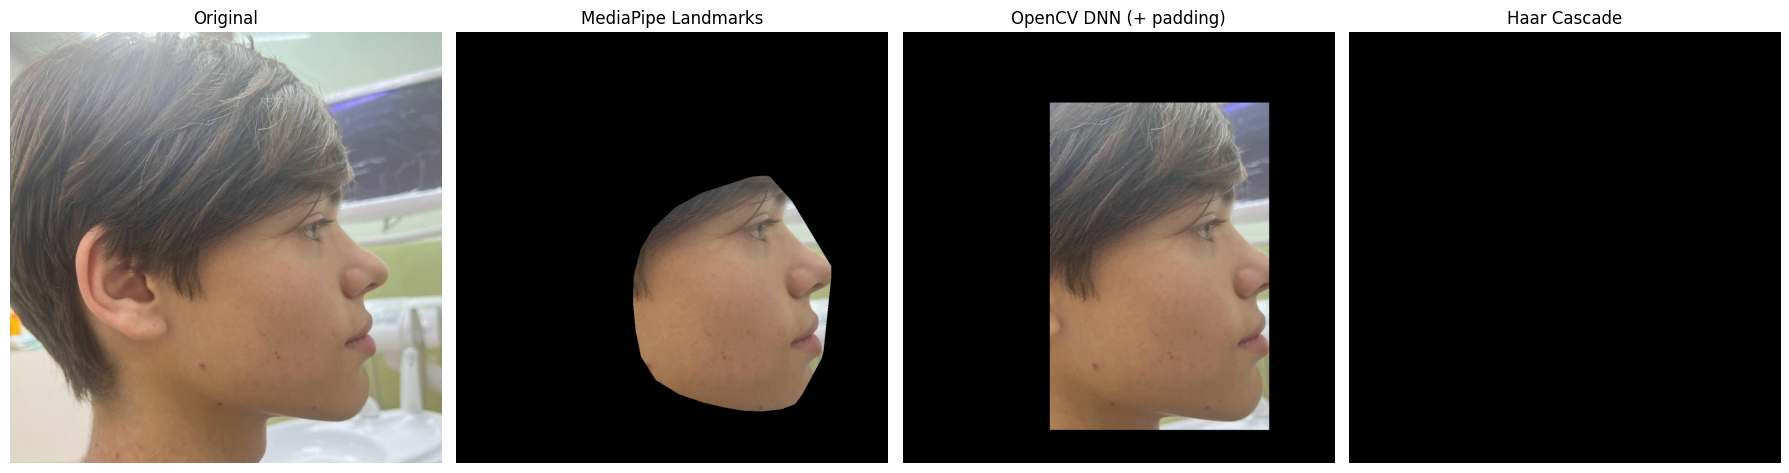


[4/5] /content/drive/MyDrive/InnerGize_Face/data/test/image_8e389f38_jpg.rf.30a97f8f2df0a3347b287be91f7d3d27.jpg
  FaceLandmarker : 16.31 ms
  OpenCV DNN SSD : 41.35 ms
  Haar Cascade  : 408.07 ms


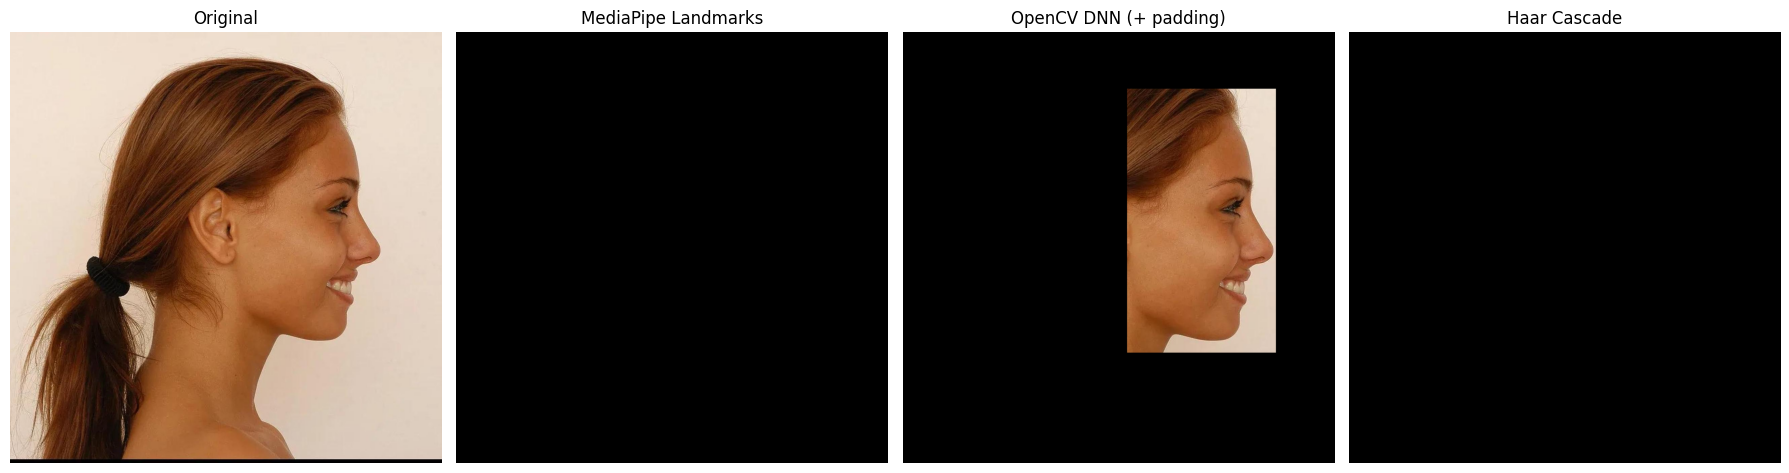


[5/5] /content/drive/MyDrive/InnerGize_Face/data/test/image_805d5569_jpg.rf.a1c840926f742f0c497a68eba3fdd866.jpg
  FaceLandmarker : 14.96 ms
  OpenCV DNN SSD : 40.30 ms
  Haar Cascade  : 598.19 ms


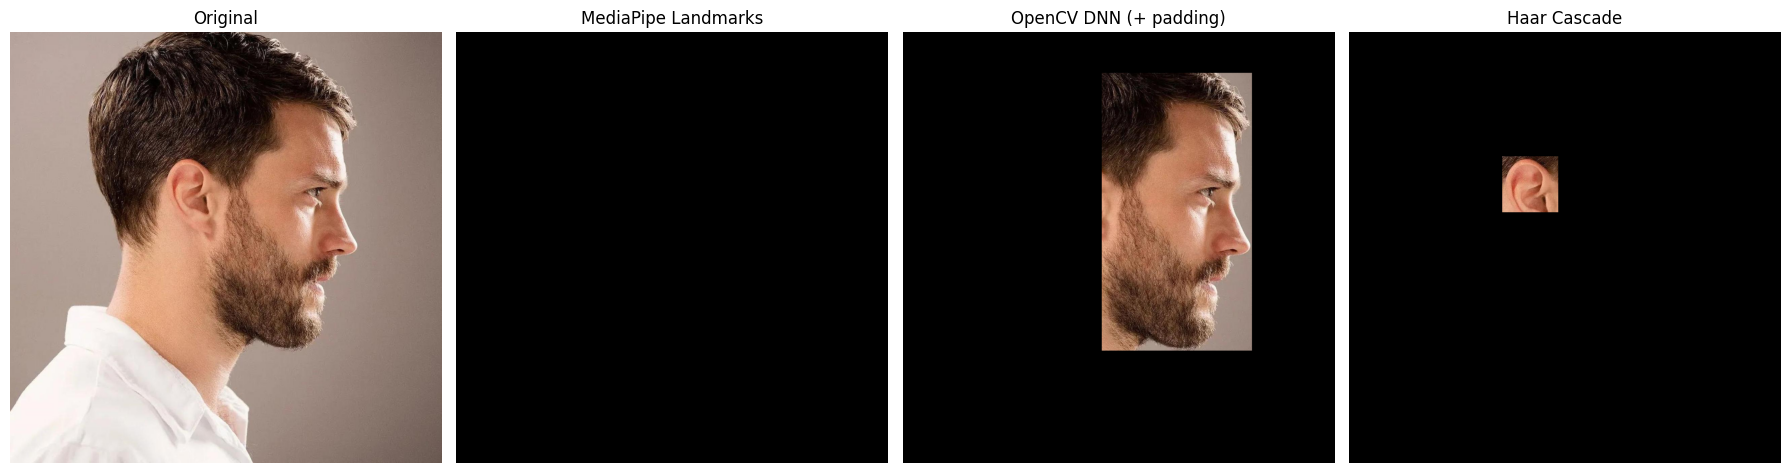

In [13]:
import os
import random
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import mediapipe as mp

from mediapipe.tasks.python import vision
from mediapipe.tasks.python import BaseOptions


IMAGE_DIR = "/content/drive/MyDrive/InnerGize_Face/data/test"
NUM_SAMPLES = 5

GENERAL_EXPAND = 20
DNN_PADDING_RATIO = 0.05


FACE_LANDMARKER_MODEL = "face_landmarker.task"

if not os.path.exists(FACE_LANDMARKER_MODEL):
    !wget -q -O face_landmarker.task \
    https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task


if not os.path.exists("deploy.prototxt"):
    !wget -q https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt

if not os.path.exists("res10_300x300_ssd_iter_140000.caffemodel"):
    !wget -q https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel


face_landmarker = vision.FaceLandmarker.create_from_options(
    vision.FaceLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=FACE_LANDMARKER_MODEL),
        num_faces=1
    )
)

dnn_net = cv2.dnn.readNetFromCaffe(
    "deploy.prototxt",
    "res10_300x300_ssd_iter_140000.caffemodel"
)

haar = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)


image_files = [
    os.path.join(IMAGE_DIR, f)
    for f in os.listdir(IMAGE_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
]

samples = random.sample(image_files, NUM_SAMPLES)


for idx, img_path in enumerate(samples, 1):
    print(f"\n[{idx}/{NUM_SAMPLES}] {img_path}")

    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape

    mp_image = mp.Image(mp.ImageFormat.SRGB, img_rgb)


    t0 = time.perf_counter()
    lm_result = face_landmarker.detect(mp_image)
    lm_time = (time.perf_counter() - t0) * 1000

    mask_lm = np.zeros((h, w), dtype=np.uint8)
    if lm_result.face_landmarks:
        pts = np.array(
            [[int(l.x * w), int(l.y * h)] for l in lm_result.face_landmarks[0]],
            dtype=np.int32
        )
        hull = cv2.convexHull(pts)
        cv2.fillConvexPoly(mask_lm, hull, 255)
        mask_lm = cv2.dilate(
            mask_lm,
            cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (GENERAL_EXPAND, GENERAL_EXPAND))
        )

    out_lm = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_lm)


    t0 = time.perf_counter()
    blob = cv2.dnn.blobFromImage(
        img_bgr, 1.0, (300, 300), (104.0, 177.0, 123.0)
    )
    dnn_net.setInput(blob)
    detections = dnn_net.forward()
    dnn_time = (time.perf_counter() - t0) * 1000

    mask_dnn = np.zeros((h, w), dtype=np.uint8)
    if detections.shape[2] > 0:
        conf = detections[0, 0, 0, 2]
        if conf > 0.5:
            x1, y1, x2, y2 = (
                detections[0, 0, 0, 3:7] * np.array([w, h, w, h])
            ).astype(int)

            bw, bh = x2 - x1, y2 - y1
            pad_w, pad_h = int(bw * DNN_PADDING_RATIO), int(bh * DNN_PADDING_RATIO)

            x1 = max(0, x1 - pad_w)
            y1 = max(0, y1 - pad_h)
            x2 = min(w, x2 + pad_w)
            y2 = min(h, y2 + pad_h)

            mask_dnn[y1:y2, x1:x2] = 255

    out_dnn = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_dnn)

    t0 = time.perf_counter()
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    faces = haar.detectMultiScale(gray, 1.1, 5)
    haar_time = (time.perf_counter() - t0) * 1000

    mask_haar = np.zeros((h, w), dtype=np.uint8)
    if len(faces):
        x, y, fw, fh = max(faces, key=lambda b: b[2] * b[3])
        mask_haar[y:y + fh, x:x + fw] = 255

    out_haar = cv2.bitwise_and(img_rgb, img_rgb, mask=mask_haar)


    print(f"  FaceLandmarker : {lm_time:.2f} ms")
    print(f"  OpenCV DNN SSD : {dnn_time:.2f} ms")
    print(f"  Haar Cascade  : {haar_time:.2f} ms")


    plt.figure(figsize=(18, 5))

    plt.subplot(1, 4, 1)
    plt.title("Original")
    plt.imshow(img_rgb)
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.title("MediaPipe Landmarks")
    plt.imshow(out_lm)
    plt.axis("off")

    plt.subplot(1, 4, 3)
    plt.title("OpenCV DNN (+ padding)")
    plt.imshow(out_dnn)
    plt.axis("off")

    plt.subplot(1, 4, 4)
    plt.title("Haar Cascade")
    plt.imshow(out_haar)
    plt.axis("off")

    plt.tight_layout()
    plt.show()


In [17]:
import os

matches = []
for root, dirs, files in os.walk("/content"):
    for name in files + dirs:
        if name.lower() == "mediapipe.py" or name.lower() == "mediapipe":
            matches.append(os.path.join(root, name))

matches


[]